In [110]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [150]:
df_test = pd.read_csv('EnefitAPI/example_test_files/test.csv')
df_test['datetime'] = df_test['prediction_datetime'].astype('datetime64[ns]')
df_gas_prices = pd.read_csv('EnefitAPI/example_test_files/gas_prices.csv')
df_client = pd.read_csv('EnefitAPI/example_test_files/client.csv')
df_elec_prices = pd.read_csv('EnefitAPI/example_test_files/electricity_prices.csv')
df_forecast_weather = pd.read_csv('EnefitAPI/example_test_files/forecast_weather.csv')
df_historical_weather = pd.read_csv('EnefitAPI/example_test_files/historical_weather.csv')
wscm = pd.read_csv('EnefitAPI/weather_station_to_county_mapping.csv')
y_rev_targets = pd.read_csv('EnefitAPI/example_test_files/revealed_targets.csv')

In [151]:
df1 = pd.merge(df_test, df_gas_prices[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']], on='data_block_id', how='left')
df2 = pd.merge(df1, df_client[['data_block_id', 'product_type', 'county', 'is_business', 'eic_count', 'installed_capacity']], 
           on=['data_block_id', 'product_type', 'county', 'is_business'], how='left')
df_elec_prices['datetime'] = df_elec_prices['forecast_date'].astype('datetime64[ns]') + pd.DateOffset(1)
df3 = pd.merge(df2, df_elec_prices[['data_block_id', 'euros_per_mwh', 'datetime']], on=['datetime', 'data_block_id'], how='left')
wscm['longitude'] = wscm['longitude'].round(1)
wscm['latitude'] = wscm['latitude'].round(1)
df_forecast_weather['datetime'] = df_forecast_weather['forecast_datetime'].astype('datetime64[ns]')
df_forecast_weather = pd.merge(df_forecast_weather, wscm[['latitude', 'longitude', 'county']], on=['latitude', 'longitude'], how='left')
mer_feat = ['temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component',
       '10_metre_v_wind_component',  'direct_solar_radiation', 
            'surface_solar_radiation_downwards', 'snowfall', 
            'total_precipitation', 'datetime', 'county', 'data_block_id']
temp = df_forecast_weather[mer_feat].groupby(['datetime', 'county', 'data_block_id']).mean().reset_index()
df4 = pd.merge(df3, temp, on=['datetime', 'county', 'data_block_id'], how='left')


df_historical_weather['datetime'] = df_historical_weather['datetime'].astype('datetime64[ns]')
df_historical_weather['datetime'] = df_historical_weather['datetime'].apply(lambda x: 
                                                      x + pd.DateOffset(1) if x.hour < 11 else x + pd.DateOffset(2))
df_historical_weather = pd.merge(df_historical_weather, wscm[['latitude', 'longitude', 'county']], on=['latitude', 'longitude'], how='left')


feat=['temperature', 'dewpoint', 'rain', 'snowfall',
       'surface_pressure', 'cloudcover_total', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_high', 'windspeed_10m',
       'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation',
       'diffuse_radiation']
feat_h = ["%s_h"%i for i in feat]
feat_dict = dict(zip(feat, feat_h))
df_historical_weather = df_historical_weather.rename(columns=feat_dict)

mer_feat = feat_h + ['datetime', 'county', 'data_block_id']
temp = df_historical_weather[mer_feat].groupby(['datetime', 'county', 'data_block_id']).mean().reset_index()
df5 = pd.merge(df4, temp, on=['datetime', 'county', 'data_block_id'], how='left')

In [152]:
df = df5.copy().drop(['prediction_unit_id'], axis=1)

In [153]:
df = df.drop('prediction_datetime', axis=1)
time_feat = ['datetime']
cat_feat = ['county', 'is_business', 'product_type', 'data_block_id', 'currently_scored']
df = df.drop(time_feat+cat_feat, axis=1)

In [130]:
with open('model_production.pkl', 'rb') as f:
    model_production = pickle.load(f)
    
with open('model_consumption.pkl', 'rb') as f:
    model_consumption = pickle.load(f)

df_train_con = df[df['is_consumption']==1].drop('is_consumption', axis=1)
df_train_pro = df[df['is_consumption']==0].drop('is_consumption', axis=1)

y_con_pred = model_consumption.predict(df_train_con.drop('row_id', axis=1))
y_pro_pred = model_production.predict(df_train_pro.drop('row_id', axis=1))

df_y_con_pred = pd.DataFrame()
df_y_con_pred['row_id'] = df_train_con['row_id']
df_y_con_pred['prediction'] = y_con_pred.clip(0)

df_y_pro_pred = pd.DataFrame()
df_y_pro_pred['row_id'] = df_train_con['row_id']
df_y_pro_pred['prediction'] = y_pro_pred.clip(0)

df_y_pred = pd.concat([df_y_pro_pred, df_y_con_pred])
df_y_pred = pd.merge(df_y_pred, y_rev_targets[['target', 'row_id']], on=['row_id'], sort=['row_id'])

321.69932327825484


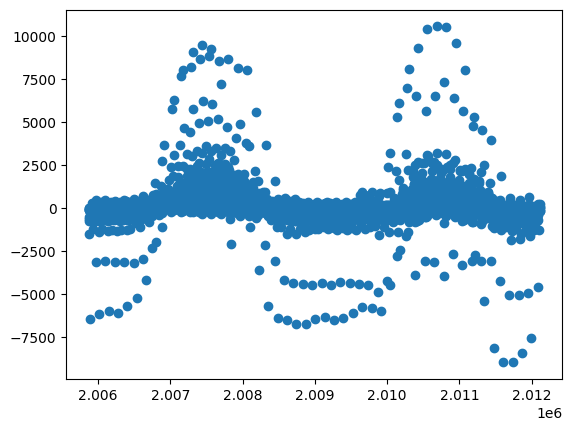

In [131]:
plt.scatter(df_y_pred['row_id'],df_y_pred['prediction']-df_y_pred['target'])
print(1/len(df_y_pred)*sum(abs(df_y_pred['prediction']-df_y_pred['target'])))
plt.show()

In [146]:
with open('model_production2.pkl', 'rb') as f:
    model_production2 = pickle.load(f)
    
with open('model_consumption2.pkl', 'rb') as f:
    model_consumption2 = pickle.load(f)
    
df_cp_model2 = df5.copy().drop(['prediction_datetime', 'data_block_id', 'prediction_unit_id', 'currently_scored', 'datetime'], axis=1)

df_train_con = df_cp_model2[df_cp_model2['is_consumption']==1].drop('is_consumption', axis=1)
df_train_pro = df_cp_model2[df_cp_model2['is_consumption']==0].drop('is_consumption', axis=1)

y_con_pred = model_consumption2.predict(df_train_con)
y_pro_pred = model_production2.predict(df_train_pro)

df_y_con_pred = pd.DataFrame()
df_y_con_pred['row_id'] = df_train_con['row_id']
df_y_con_pred['prediction'] = y_con_pred.clip(0)

df_y_pro_pred = pd.DataFrame()
df_y_pro_pred['row_id'] = df_train_con['row_id']
df_y_pro_pred['prediction'] = y_pro_pred.clip(0)

df_y_pred = pd.concat([df_y_pro_pred, df_y_con_pred])
df_y_pred = pd.merge(df_y_pred, y_rev_targets[['target', 'row_id']], on=['row_id'], sort=['row_id'])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

532.7207776765678


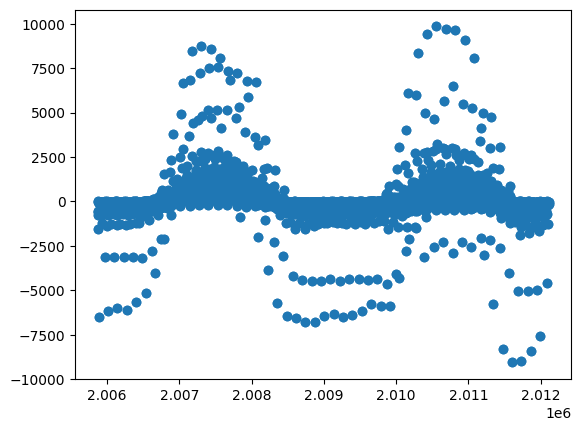

In [154]:
plt.scatter(df_y_pred['row_id'],df_y_pred['prediction']-df_y_pred['target'])
print(1/len(df_y_pred)*sum(abs(df_y_pred['prediction']-df_y_pred['target'])))
plt.show()

In [155]:
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

y_pred = pd.DataFrame()
y_pred['prediction'] = model.predict(df.drop(['row_id', 'is_consumption'], axis=1)).clip(0)
y_pred['row_id'] = df['row_id']
y_pred = pd.merge(y_pred, y_rev_targets[['target', 'row_id']], on=['row_id'], sort=['row_id'])

[LightGBM] [Warning] lambda_l1 is set=3.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5
[LightGBM] [Warning] lambda_l2 is set=1.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l1 is set=3.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5
[LightGBM] [Warning] lambda_l2 is set=1.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l1 is set=3.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5
[LightGBM] [Warning] lambda_l2 is set=1.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_l

289.99930723700356


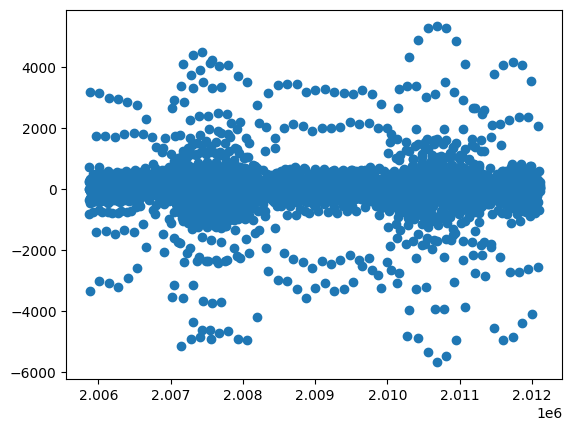

In [156]:
plt.scatter(y_pred['row_id'], y_pred['prediction']-y_pred['target'])
print(1/len(y_pred)*sum(abs(y_pred['prediction']-y_pred['target'])))
plt.show()

In [157]:
with open('model2.pkl', 'rb') as f:
    model2 = pickle.load(f)

df_model2 = df5.copy().drop(['prediction_datetime', 'data_block_id', 'prediction_unit_id', 'currently_scored', 'datetime'], axis=1)

y_pred = pd.DataFrame()
y_pred['prediction'] = model2.predict(df_model2.drop(['row_id'], axis=1)).clip(0)
y_pred['row_id'] = df['row_id']
y_pred = pd.merge(y_pred, y_rev_targets[['target', 'row_id']], on=['row_id'], sort=['row_id'])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

139.2331798138193


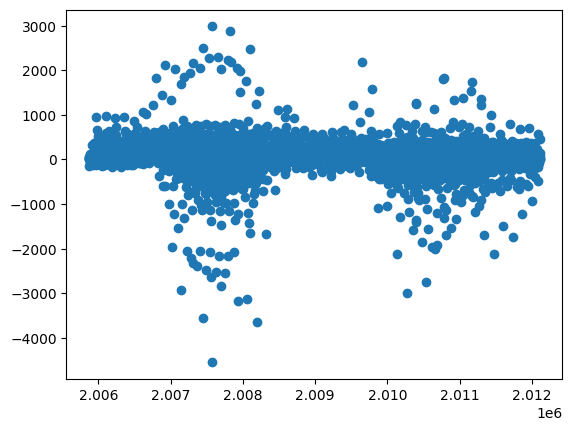

In [159]:
plt.scatter(y_pred['row_id'], y_pred['prediction']-y_pred['target'])
print(1/len(y_pred)*sum(abs(y_pred['prediction']-y_pred['target'])))
plt.show()